Best hyperparameters: {'activation': 'tanh', 'alpha': 0.1, 'hidden_layer_sizes': (64, 64), 'solver': 'adam'}


In [ ]:
!pip install torch==1.12.1+cu113 torchvision==0.13.1+cu113 torchaudio==0.12.1 -f https://download.pytorch.org/whl/cu113/torch_stable.html
!pip install --extra-index-url=https://pypi.nvidia.com cudf-cu11==24.6.0
!pip install --extra-index-url=https://pypi.nvidia.com dask-cudf-cu12==24.6.0

In [ ]:
import pandas as pd
import cudf
import dask
import dask.dataframe as dd
dask.config.set(DASK_DATAFRAME__BACKEND=cudf)
# dask.config.set({"dataframe.backend": "cudf"})
pqdf = dd.read_parquet('/content/drive/MyDrive/datasharing-dir/francetax.parquet')


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
folder_path = '/content/drive/MyDrive/datasharing-dir'
os.chdir(folder_path)

Mounted at /content/drive


In [ ]:
import pandas as pd
df= pd.read_csv('/content/drive/MyDrive/datasharing-dir/selected_features.csv')
df.drop(columns=['Unnamed: 0'], inplace=True)
# print(df.columns)
import warnings
warnings.filterwarnings('ignore')
df = df[['Total_Tax_Revenue',
         'CFE - CHAMBRE DES METIERS / DROIT FIXE / MONTANT',
         "FNB - CHAMBRE D'AGRICULTURE / MONTANT REEL",
         'IFER STATIONS RADIOELECTRIQUES ART 1519 H DU CGI / COMMUNE / MONTANT',
         "TF - DEGREVEMENT D'OFFICE  /  COTISATIONS < 12 EUROS - MONTANT",
         'TH - COTISATIONS < 12 EUROS (TOTAL DONT REFORME TH) - MONTANT',
         'TH - DEGREVEMENTS GESTIONNAIRES DE FOYERS - MONTANT',
         'TH - NON-VALEURS HORS REFORME TH - MONTANT']]
# Select the relevant columns
df = df.sample(n=50000, random_state=42)
X = df.drop(columns=['Total_Tax_Revenue'])
y = df['Total_Tax_Revenue']


### 300000 samples

In [ ]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'hidden_layer_sizes': [(64,), (128,), (64, 64)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001, 0.01, 0.1]
}

# Create the Neural Network model
nn = MLPRegressor()

# Perform grid search
grid_search = GridSearchCV(nn, param_grid, cv=5, scoring='r2')
grid_search.fit(X, y)

# Get the best hyperparameters
best_params = grid_search.best_params_
print(f"Best hyperparameters: {best_params}")

Best hyperparameters: {'activation': 'tanh', 'alpha': 0.1, 'hidden_layer_sizes': (64, 64), 'solver': 'adam'}


In [ ]:
df.shape

(50000, 8)

Cross-validation scores: [-0.04881809 -0.08058116 -0.03872515 -0.65256564  0.00761196]
Mean R2 score: -0.1626
Standard deviation of R2 score: 0.2466
R-squared score on test set: -0.0743


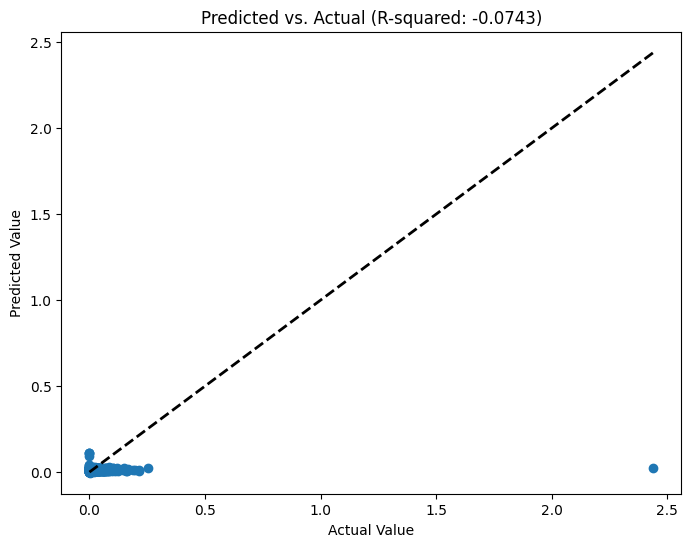

In [ ]:
from sklearn.neural_network import MLPRegressor
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

new_column_names = {'CFE - CHAMBRE DES METIERS / DROIT FIXE / MONTANT': 'cfe',
                     "FNB - CHAMBRE D'AGRICULTURE / MONTANT REEL": 'fnb',
                     'IFER STATIONS RADIOELECTRIQUES ART 1519 H DU CGI / COMMUNE / MONTANT': 'ifer',
                     "TF - DEGREVEMENT D'OFFICE  /  COTISATIONS < 12 EUROS - MONTANT": 'tf',
                     'TH - COTISATIONS < 12 EUROS (TOTAL DONT REFORME TH) - MONTANT': 'th-cotisations',
                     'TH - DEGREVEMENTS GESTIONNAIRES DE FOYERS - MONTANT': 'th-degrevements',
                     'TH - NON-VALEURS HORS REFORME TH - MONTANT': 'th-hors',
                     }
X = X.rename(columns=new_column_names)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the XGBoost Regressor with the best parameters
best_mlp = MLPRegressor(

    hidden_layer_sizes=  (64, 64),
    activation=  'tanh',
    solver= 'adam',
    alpha= 0.1
)

# Perform 5-fold cross-validation
cv_scores = cross_val_score(best_mlp, X, y, cv=5, scoring='r2')

# Print the results
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean R2 score: {np.mean(cv_scores):.4f}")
print(f"Standard deviation of R2 score: {np.std(cv_scores):.4f}")

# Train the final model on the entire dataset
best_mlp.fit(X_train, y_train)

# Predict on the test set
y_pred = best_mlp.predict(X_test)

# Calculate the R-squared score on the test set
r2 = r2_score(y_test, y_pred)
print(f"R-squared score on test set: {r2:.4f}")

# Plot the predicted values vs. actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
plt.title(f'Predicted vs. Actual (R-squared: {r2:.4f})')
plt.show()

